In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.2.0


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [ ]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-06-01 10:08:57--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.009s  

2020-06-01 10:08:57 (7.52 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



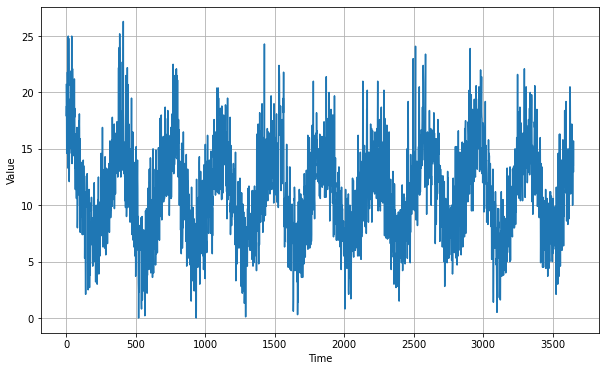

In [ ]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter = ",")
    next(reader)
    i = 1
    for row in reader:
      time_step.append(i)
      temps.append(float(row[1]))
      i += 1
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [ ]:
split_time = 2500
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift = 1, drop_remainder = True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [ ]:
def model_forecast(model, series, window_size):
    dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
    return dataset

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [None]),
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "causal", activation = "relu"),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Dense(32, activation = "relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


[1e-08, 0.0001, 0, 60]

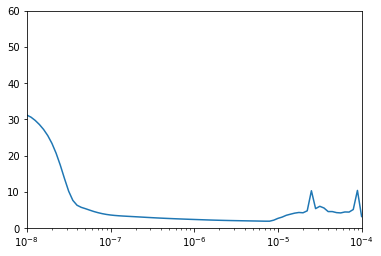

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = -1), input_shape = [window_size]),
  tf.keras.layers.Conv1D(filters = 32, kernel_size = 5, strides = 1, padding = "causal", activation = "relu"),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences = True)),
  tf.keras.layers.Dense(32, activation = "relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])


optimizer = tf.keras.optimizers.SGD(lr = 1e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs = 500)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/500
25/25 [==============================] - 0s 16ms/step - loss: 15.2443 - mae: 15.7368
Epoch 2/500
25/25 [==============================] - 0s 16ms/step - loss: 4.1105 - mae: 4.5861
Epoch 3/500
25/25 [==============================] - 0s 16ms/step - loss: 3.1523 - mae: 3.6203
Epoch 4/500
25/25 [==============================] - 0s 16ms/step - loss: 2.7337 - mae: 3.1985
Epoch 5/500
25/25 [==============================] - 0s 17ms/step - loss: 2.5528 - mae: 3.0155
Epoch 6/500
25/25 [==============================] - 0s 16ms/step - loss: 2.4747 - mae: 2.9360
Epoch 7/500
25/25 [==============================] - 0s 16ms/step - loss: 2.4436 - mae: 2.9044
Epoch 8/500
25/25 [==============================] - 0s 16ms/step - loss: 2.4202 - mae: 2.8810
Epoch 9/500
25/25 [==============================] - 0s 17ms/step - loss: 2.4022 - mae: 2.8626
Epoch 10/500
25/25 [==============================] - 0s 16ms/step - loss: 2.3892 - mae: 2.8495
Epoch 11/500
25/25 [===========================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

TypeError: ignored

TypeError: ignored

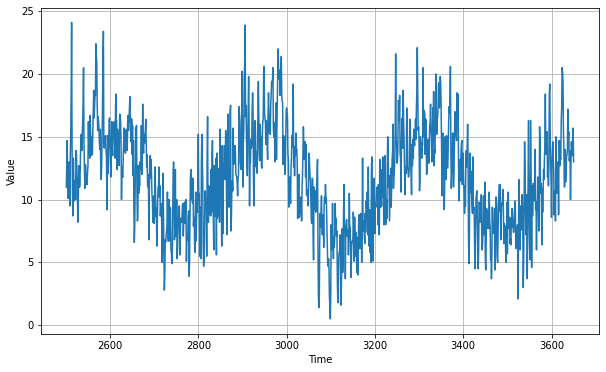

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

ValueError: ignored

In [ ]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
